# Complaints Analysis

## Imports

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import numpy as np
import seaborn as sns
import string
import pprint
from wordcloud import WordCloud
from helpers.utilities import (
    fill_string_nulls,
    trim_strings
)

In [3]:
PARENT_DIR = os.getcwd().rsplit("\\", maxsplit=1)[0]
DATASET_DIR = os.path.join(PARENT_DIR, "Datasets")

## Utilities

In [4]:
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.alpha"] = "0.2"
plt.rcParams["grid.linestyle"] = "-."

In [7]:
def get_random_row(df : pd.DataFrame):
    rand_row = df.sample().iloc[0]
    print("ODINO:", rand_row["ODINO"])
    pprint.pprint(f"FAILDATE: {rand_row['FAILDATE']}")
    pprint.pprint(f"CITY: {rand_row['CITY']}")
    pprint.pprint(f"STATE: {rand_row['STATE']}")
    pprint.pprint(f"COMPDESC: {rand_row['COMPDESC']}")
    pprint.pprint(f"CDESCR: {rand_row['CDESCR']}")

In [8]:
def plot_distrib(df: pd.DataFrame, column_name: str,
                bins=None):
    '''
      Plot distribution on histogram
      :param df: polars dataframe
      :param column_name: column name to plot distribution of
      :param bins: number of bins to use
    '''
    fig, ax = plt.subplots()
    if bins is None:
      ## Assume values ar from range 1 to num_unique if bins are not specified
      num_unique = len(df[column_name].unique())
      bins = [i+1 for i in range(num_unique+1)]

    _, _, patches = ax.hist(x=df[column_name], align='left',
                bins=bins,
                rwidth=0.8)
    _ = ax.set_title(f"Distribution of {column_name}")
    _ = ax.set_ylabel("Number of Reviews")
    _ = ax.set_xlabel(column_name)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_locator(ticker.FixedLocator(bins[:-1]))
    totals = sum(ax.containers[0].datavalues)
    max_bar_height = max([patch.get_height() for patch in patches])
    slight_padding = max_bar_height * 0.01
    for i, patch in enumerate(patches):
      bar_height = patch.get_height()
      proportion_of_max_height = bar_height / max_bar_height
      if proportion_of_max_height < 0.05:
        # Place the label above the bar
        ax.text(patch.get_x() + patch.get_width() / 2, bar_height + slight_padding, f'{bar_height/totals*100:.2f}%',
                ha='center', va='bottom', color='black')
      else:
        # Place the label inside the bar
        ax.text(patch.get_x() + patch.get_width() / 2, bar_height - slight_padding, f'{bar_height/totals*100:.2f}%',
                ha='center', va='top', color='white')
    # ax.bar_label(ax.containers[0], color="white",
    #              padding=-15,
    #              labels=[f"{x/totals * 100:.2f}%"
    #                      if not np.isclose(x, 0) else ""
    #                      for x in ax.containers[0].datavalues])
    return fig, ax


## Load Complaints Dataset

In [9]:
df_complaints = pd.read_csv(f"{DATASET_DIR}/COMPLAINTS_RECEIVED_2025-2025.txt", sep='\t', header=None, index_col=0)
df_complaints.columns = ['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH', 'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE', 'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE', 'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
              'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE', 'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE', 'RESTRAINT_TYPE', 'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY', 'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']

C:\Users\harri\AppData\Local\Temp\ipykernel_52652\1253059527.py:1: DtypeWarning: Columns (29,32,35,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_complaints = pd.read_csv(f"{DATASET_DIR}/COMPLAINTS_RECEIVED_2025-2025.txt", sep='\t', header=None, index_col=0)


## Preprocessing

In [10]:
df_complaints["MMYTXT"] = (
    df_complaints["MAKETXT"] + " " + df_complaints["MODELTXT"] + " " + df_complaints["YEARTXT"].astype(str)
)

## Descriptive Summary

In [11]:
df_complaints.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY',
       'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', 'REPAIRED_YN',
       'MEDICAL_ATTN', 'VEHICLES_TOWED_YN', 'MMYTXT'],
      dtype='object')

In [12]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17239 entries, 2051723 to 2068962
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ODINO              17239 non-null  int64  
 1   MFR_NAME           17239 non-null  object 
 2   MAKETXT            17239 non-null  object 
 3   MODELTXT           17239 non-null  object 
 4   YEARTXT            17239 non-null  int64  
 5   CRASH              17239 non-null  object 
 6   FAILDATE           17239 non-null  int64  
 7   FIRE               17239 non-null  object 
 8   INJURED            17239 non-null  int64  
 9   DEATHS             17239 non-null  int64  
 10  COMPDESC           17239 non-null  object 
 11  CITY               17236 non-null  object 
 12  STATE              17239 non-null  object 
 13  VIN                16907 non-null  object 
 14  DATEA              17239 non-null  int64  
 15  LDATE              17239 non-null  int64  
 16  MILES              

### CDESCR String Length

In [13]:
df_string_length = df_complaints["CDESCR"].drop_duplicates().str.len()

In [14]:
df_string_length.describe()

count    11626.000000
mean       617.240237
std        454.429421
min          1.000000
25%        285.000000
50%        523.000000
75%        808.000000
max       2048.000000
Name: CDESCR, dtype: float64

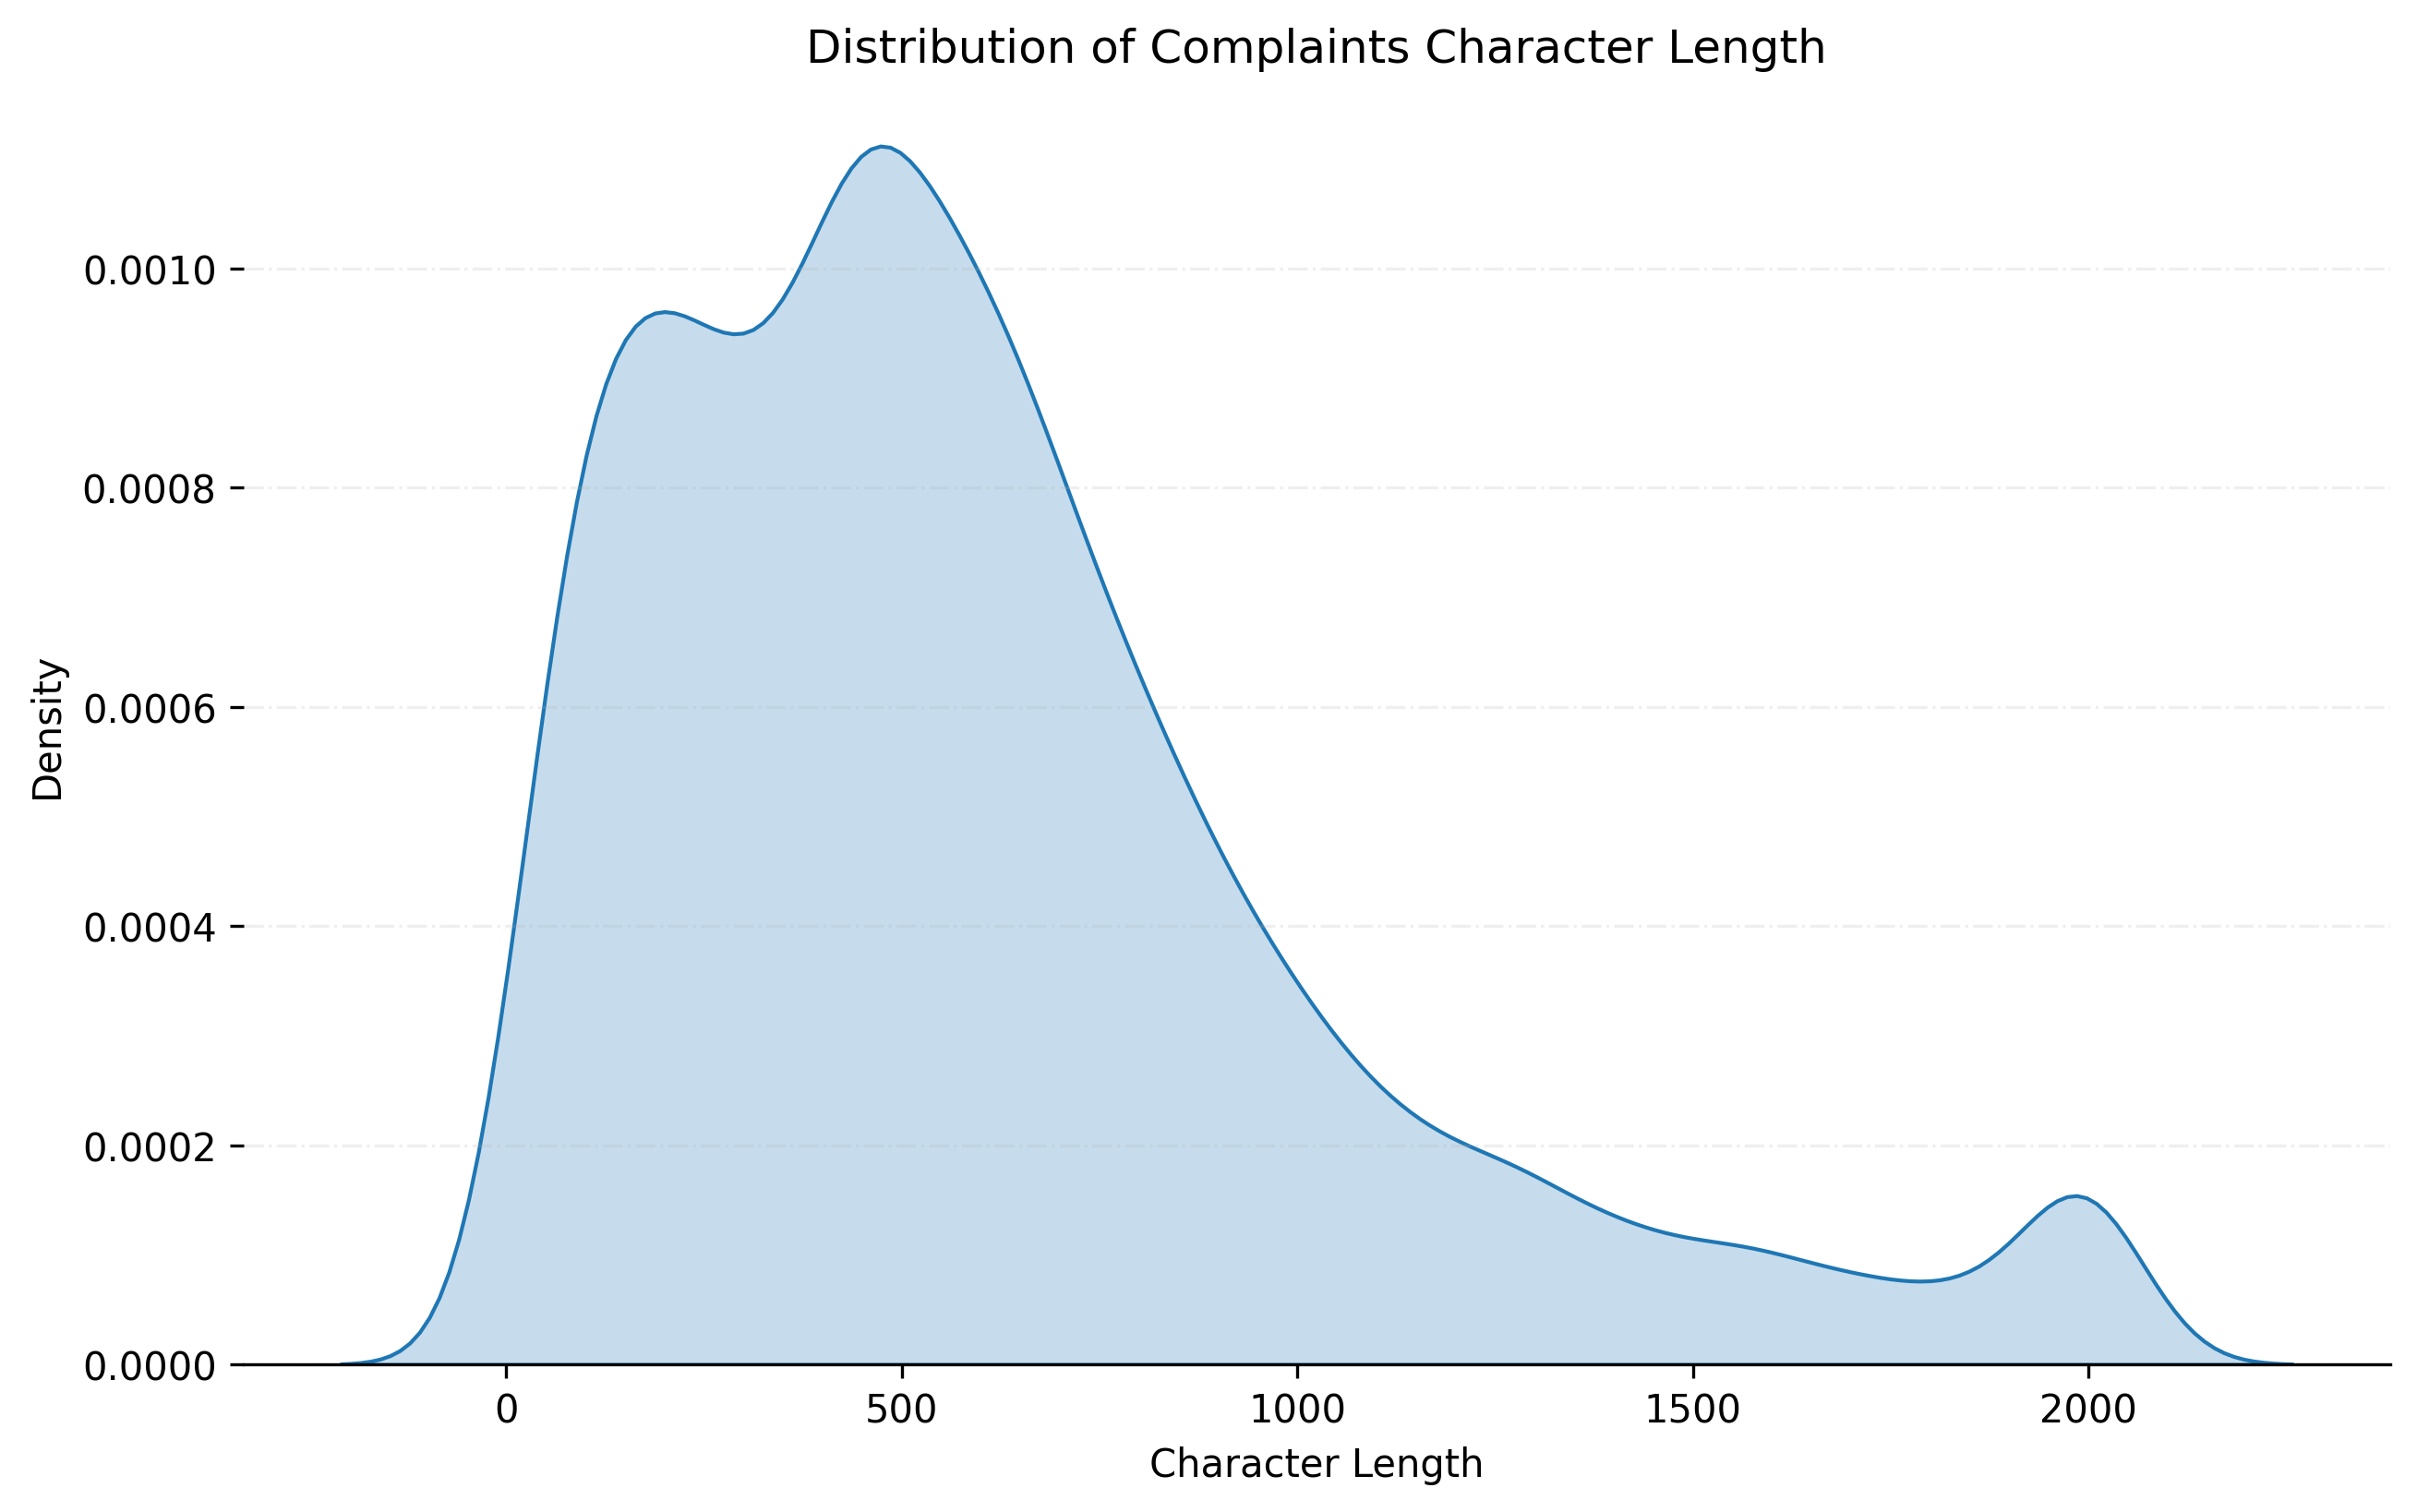

In [15]:
plt.figure(figsize=(10, 6), dpi=300)
sns.kdeplot(data=df_string_length, fill=True)
plt.title("Distribution of Complaints Character Length")
plt.xlabel("Character Length")
plt.ylabel("Density")
plt.show()


Why are complaints so long

#### General Distribution of Make

In [16]:
df_complaints["MAKETXT"].unique()

array(['FORD', 'JEEP', 'TOYOTA', 'BUICK', 'HONDA', 'TESLA', 'VOLKSWAGEN',
       'GMC', 'DODGE', 'HYUNDAI', 'CFMOTO', 'CHRYSLER', 'KIA', 'TBD',
       'VOLVO', 'MERCEDES-BENZ', 'CHEVROLET', 'BMW', 'RAM', 'MAZDA',
       'UNKNOWN', 'ACURA', 'LINCOLN', 'SUBARU', 'CADILLAC',
       'GRAND DESIGN', 'NISSAN', 'GOODYEAR', 'HANKOOK', 'LEXUS', 'HUMMER',
       'EVENFLO', 'GENESIS', 'HARLEY-DAVIDSON', 'JAGUAR', 'MERCURY',
       'PETERBILT', 'TAXA', 'NUNA', 'LAND ROVER', 'KEYSTONE',
       'MERCEDES BENZ', 'FISKER', 'FIRESTONE', 'INFINITI', 'MITSUBISHI',
       'CHICCO', 'POLESTAR', 'FREIGHTLINER', 'MEVOTECH', 'AUDI',
       'BLUE OX', 'CONTINENTAL TIRE', 'FOREST RIVER', 'GENESIS SUPREME',
       'FIAT', 'MINI', 'PONTIAC', 'MAXI-COSI', 'JAYCO', 'PORSCHE',
       'RIVIAN', 'POLARIS', 'LUCID', 'ENEL X', 'CONTINENTAL',
       'THOR MOTOR COACH', 'LANCE CAMPER', 'ASTON MARTIN', 'VINFAST',
       'COOPER', 'KARAVAN', 'COSCO', 'SATURN', 'ALFA ROMEO',
       'READING TRUCK BODY', 'NEWMAR', 'FLEETWOOD'

In [17]:
maketxt_value_counts = df_complaints.groupby("MAKETXT").nunique("CDESCR")["CDESCR"].sort_values(ascending=False)[:50]

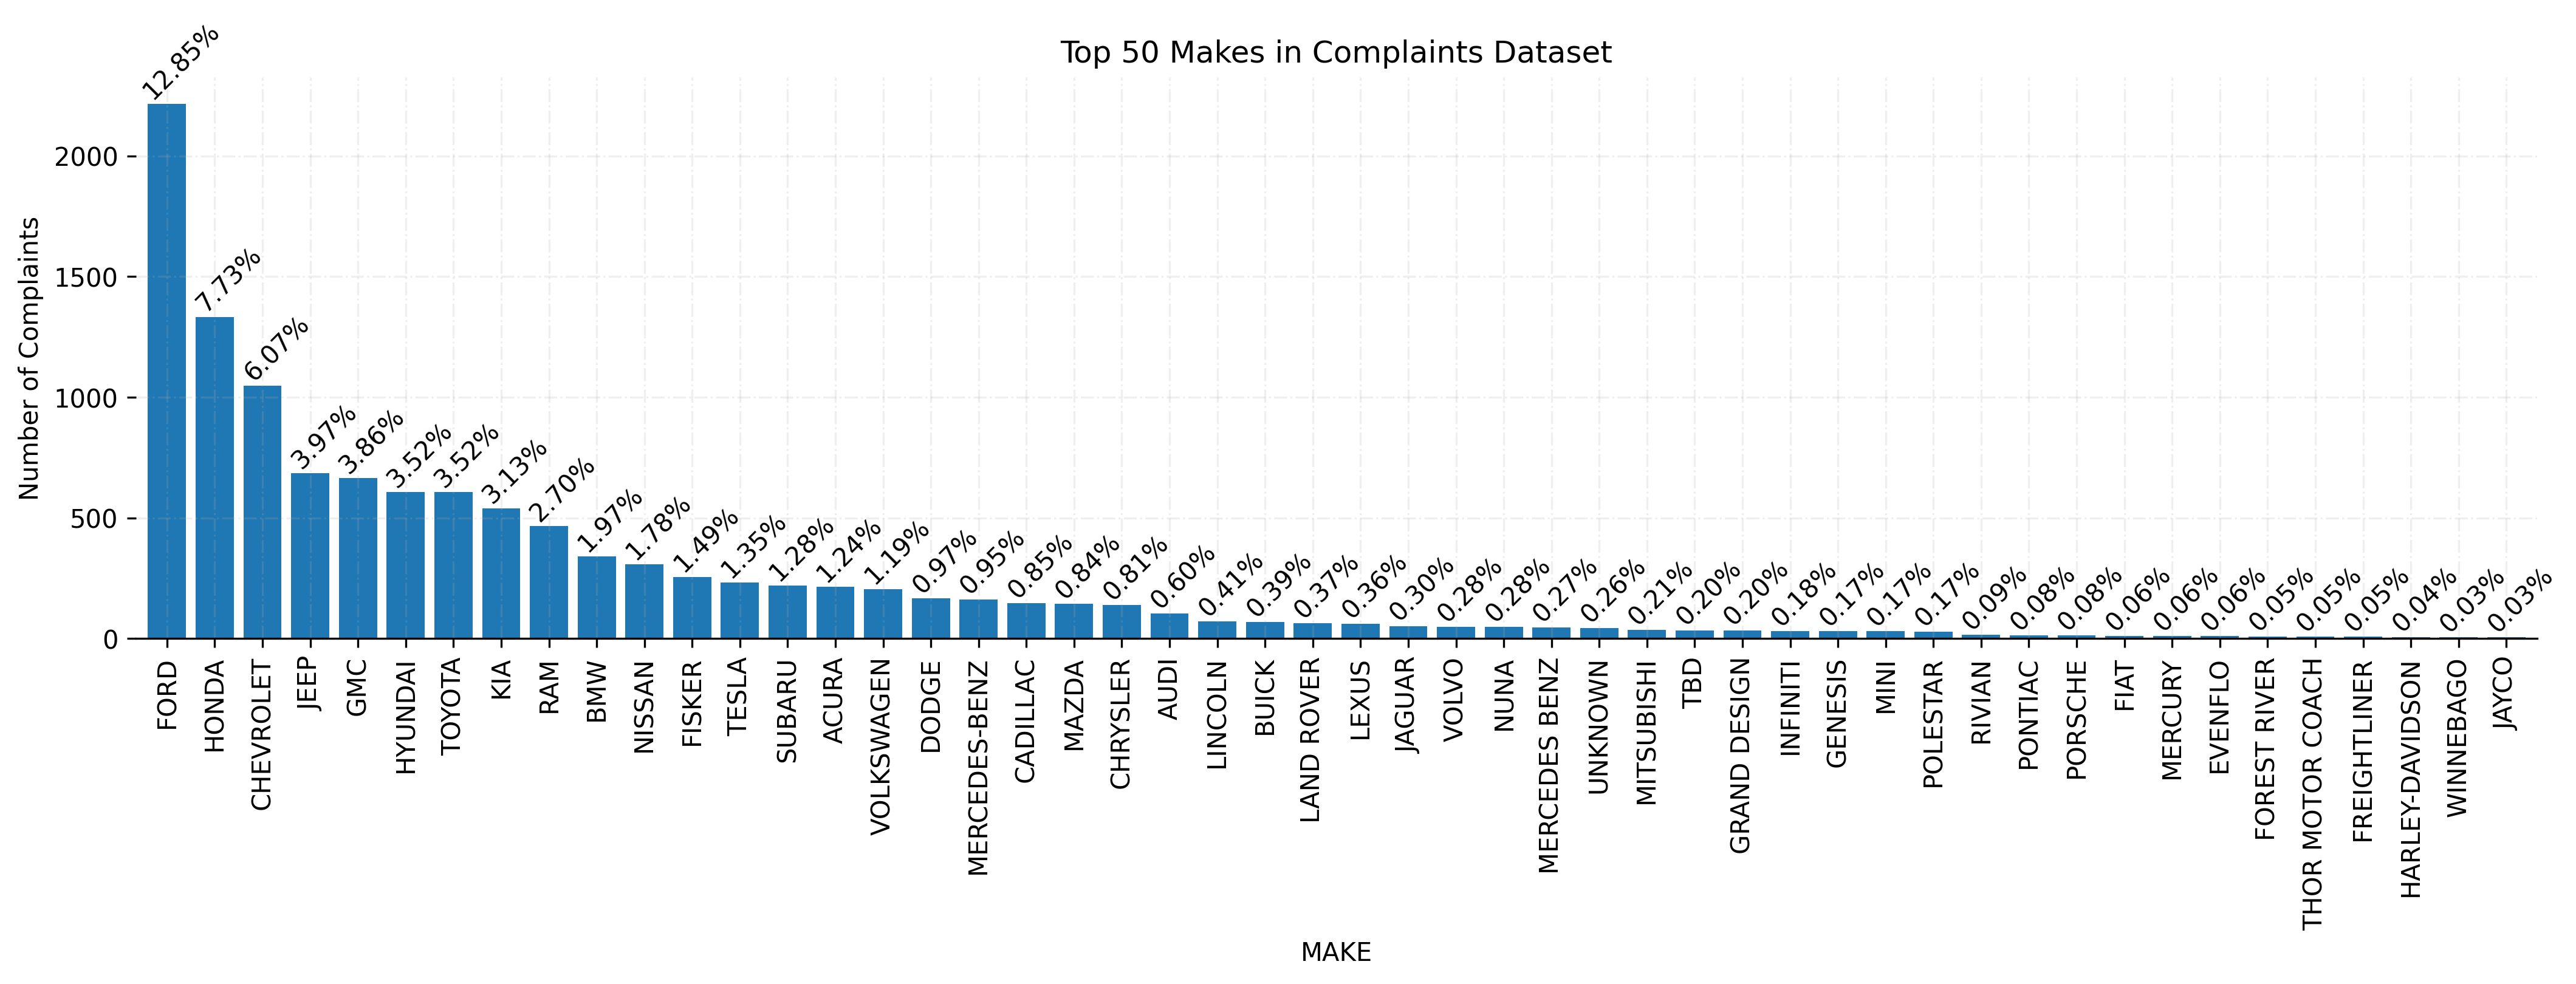

In [18]:
# Plot MAKETXT value counts with percentage text hovering over bar chart
plt.figure(figsize=(17, 4), dpi=300)
maketxt_value_counts.plot(kind='bar', width=0.8)
for i, count in enumerate(maketxt_value_counts):
    plt.text(i + 0.3, count, f"{count / len(df_complaints) * 100:.2f}%", ha='center', va='bottom', rotation=45)
plt.title('Top 50 Makes in Complaints Dataset')
plt.xlabel('MAKE')
plt.ylabel('Number of Complaints')
plt.show()

### CMPL_TYPE 

In [19]:
df_complaints["CMPL_TYPE"].unique()

array(['IVOQ', 'EVOQ'], dtype=object)

In [20]:
complaints_value_counts = df_complaints.drop_duplicates("CDESCR")["CMPL_TYPE"].value_counts()

In [21]:
complaints_value_counts = complaints_value_counts.reset_index().replace(
    {
        "IVOQ" : "NHTSA Website",
        "EVOQ" : "Hotline VOQ"
    }
)

In [22]:
complaints_value_counts

,CMPL_TYPE,count
0,NHTSA Website,8963
1,Hotline VOQ,2664


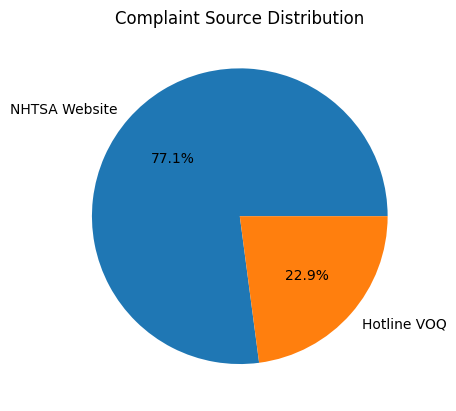

In [23]:
plt.figure(dpi=100)
_ = plt.pie(
    complaints_value_counts["count"], labels=complaints_value_counts["CMPL_TYPE"], autopct='%1.1f%%'
)
_ = plt.title("Complaint Source Distribution")

### Complaints Wordmap

In [25]:
# complaints_word_freq = generate_word_frequencies_from_column(df_complaints, "CDESCR")


In [24]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(complaints_word_freq.to_dict()["count"])

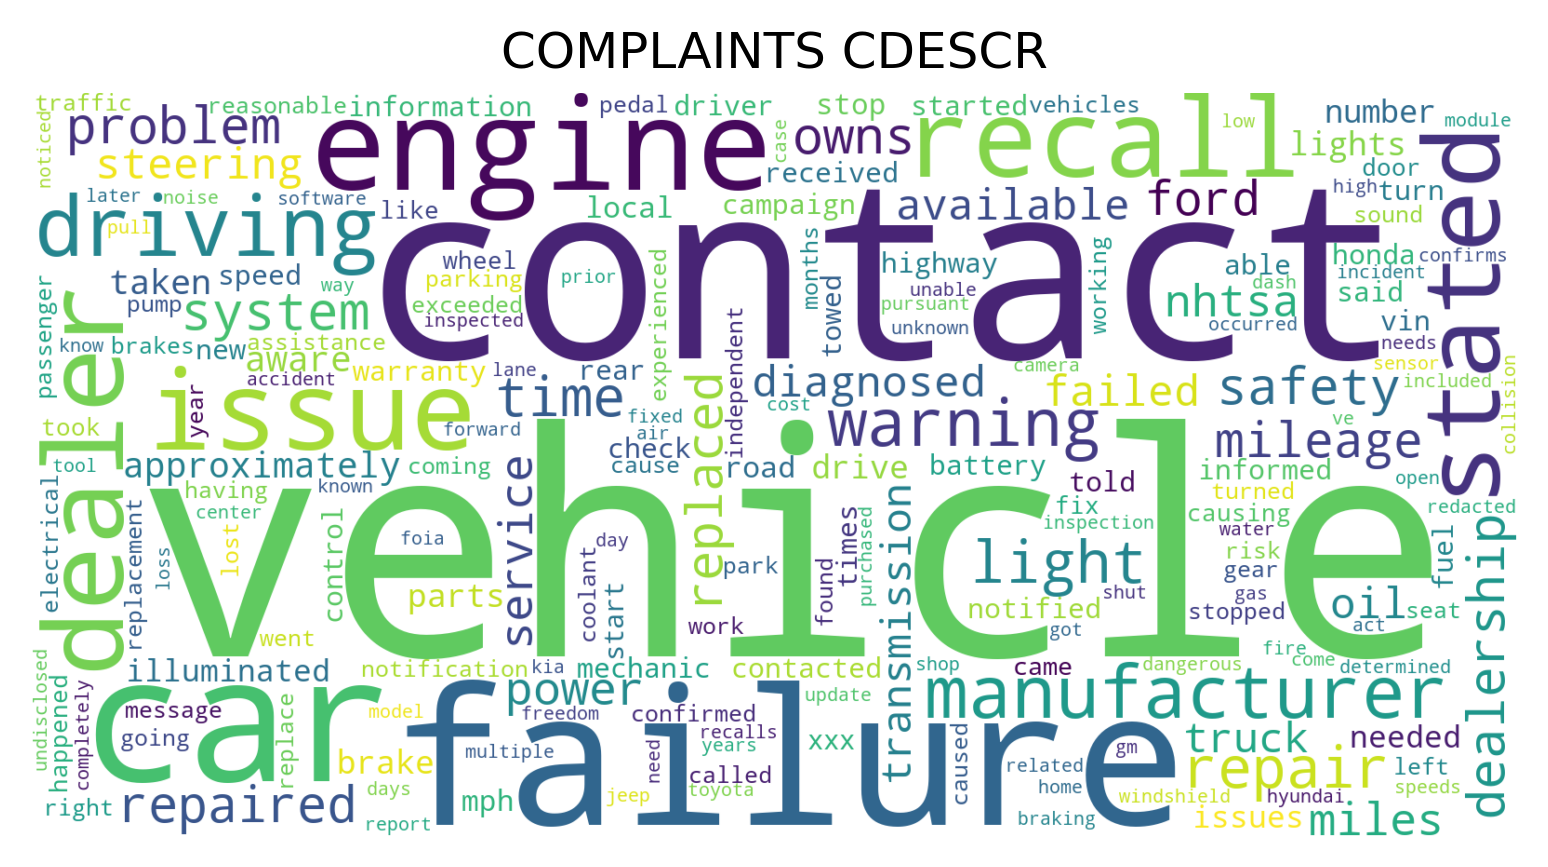

In [25]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPLAINTS CDESCR')

In [28]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                regexp="\\b\\w\\w+\\b",
                include_numbers=False,
                collocations=True,
                stopwords=nlp.Defaults.stop_words,
                collocation_threshold=-999,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate(df_complaints["CDESCR"].drop_duplicates().str.cat(sep=" "))

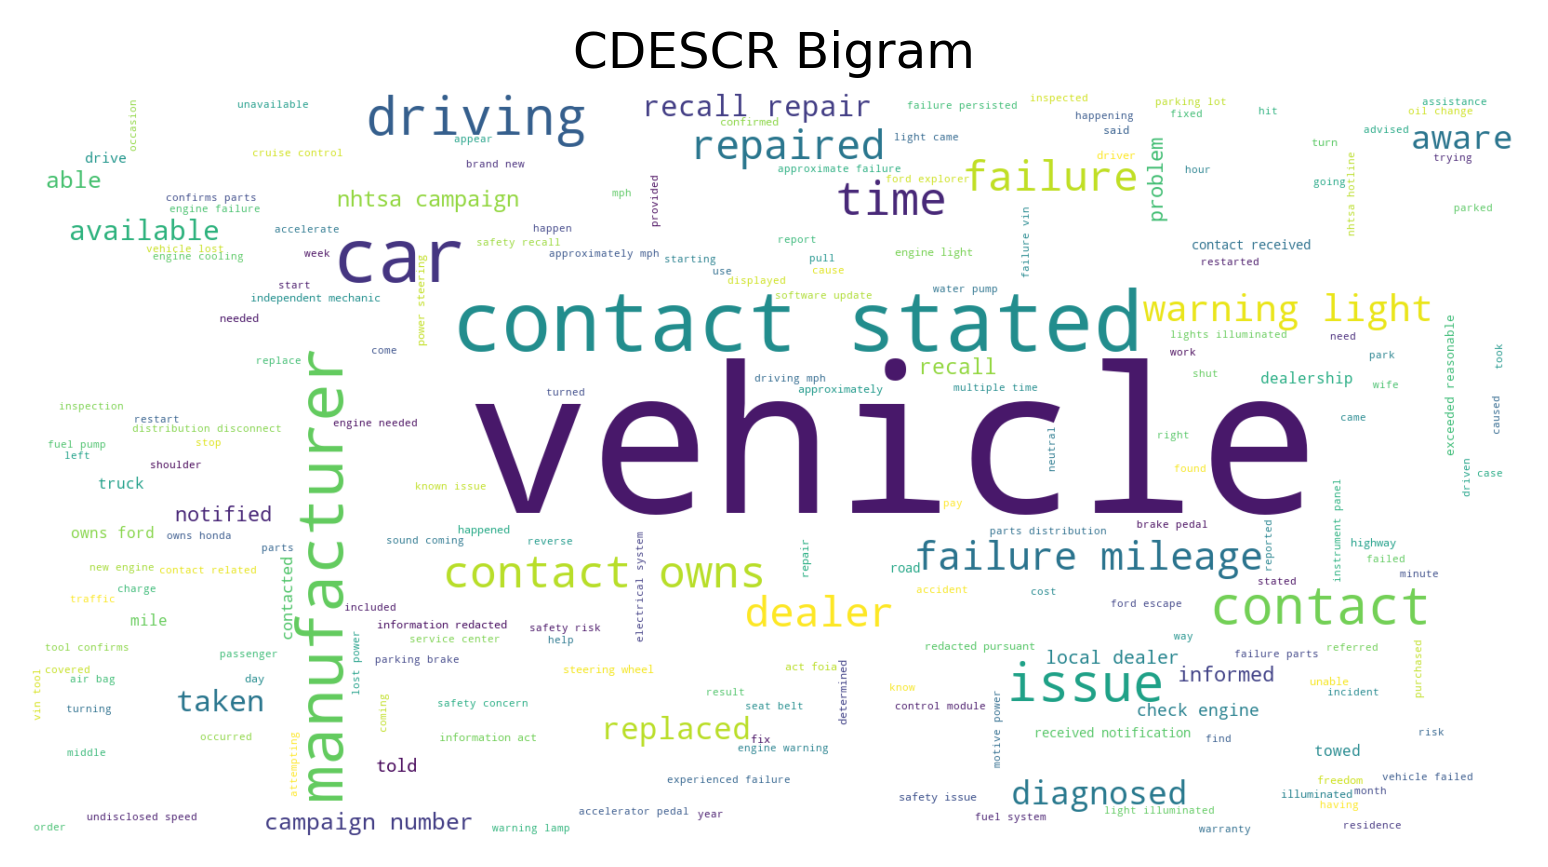

In [29]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('CDESCR Bigram')

In [31]:
get_random_row(df_complaints[
    df_complaints["CDESCR"].fillna("").str.contains("engine stall")
])   

ODINO: 11640577
'FAILDATE: 20240223'
'CITY: Clarksville'
'STATE: TN'
'COMPDESC: VEHICLE SPEED CONTROL'
('CDESCR: 2022 Honda pilot will have engine stall and will not accelerate '
 'while in motion.  First time it happened was February 2024. Vehicle '
 'completely stalled in traffic and would no longer accelerate. Vehicle had to '
 'get pushed out of traffic and towed to Honda dealership. Honda service '
 'department replaced the transmission saying that was the issue and reason '
 'the vehicle engine was stalling. Vehicle has continually stalled but not as '
 'severe as the first time throughout the year of 2024. It is now 2025 and '
 'vehicle is progressively stalling more frequently.  Honda says there is no '
 'recall for what is occurring to the 2022 Honda Pilot, but is now having the '
 'same engine stalling issue while in motion with their Honda Pilot 2023-2025 '
 'models having over 295,000 vehicles involved in a recall reported through '
 'National Highway Traffic Safety Adminis

### COMPNAME Distribution

Name of component with defect

In [31]:
compname_word_freq = generate_word_frequencies_from_column(df_complaints, "COMPDESC")

In [32]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(compname_word_freq.to_dict()["count"])

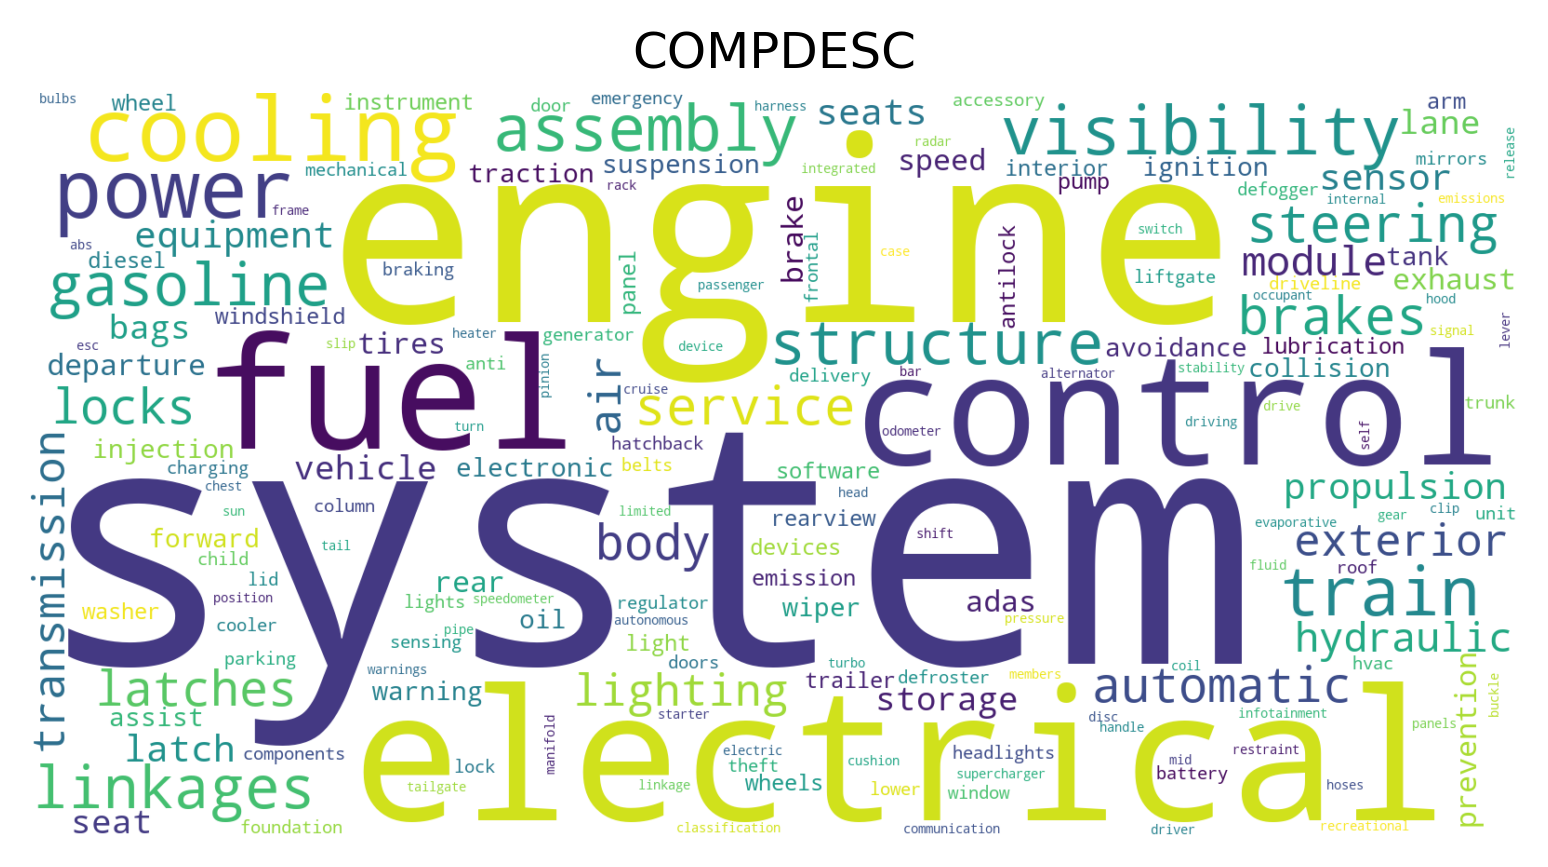

In [33]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPDESC')

In [34]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                regexp="\\b\\w\\w+\\b",
                include_numbers=False,
                collocations=True,
                stopwords=nlp.Defaults.stop_words,
                collocation_threshold=-999,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate(df_complaints["COMPDESC"].drop_duplicates().str.cat(sep=" "))

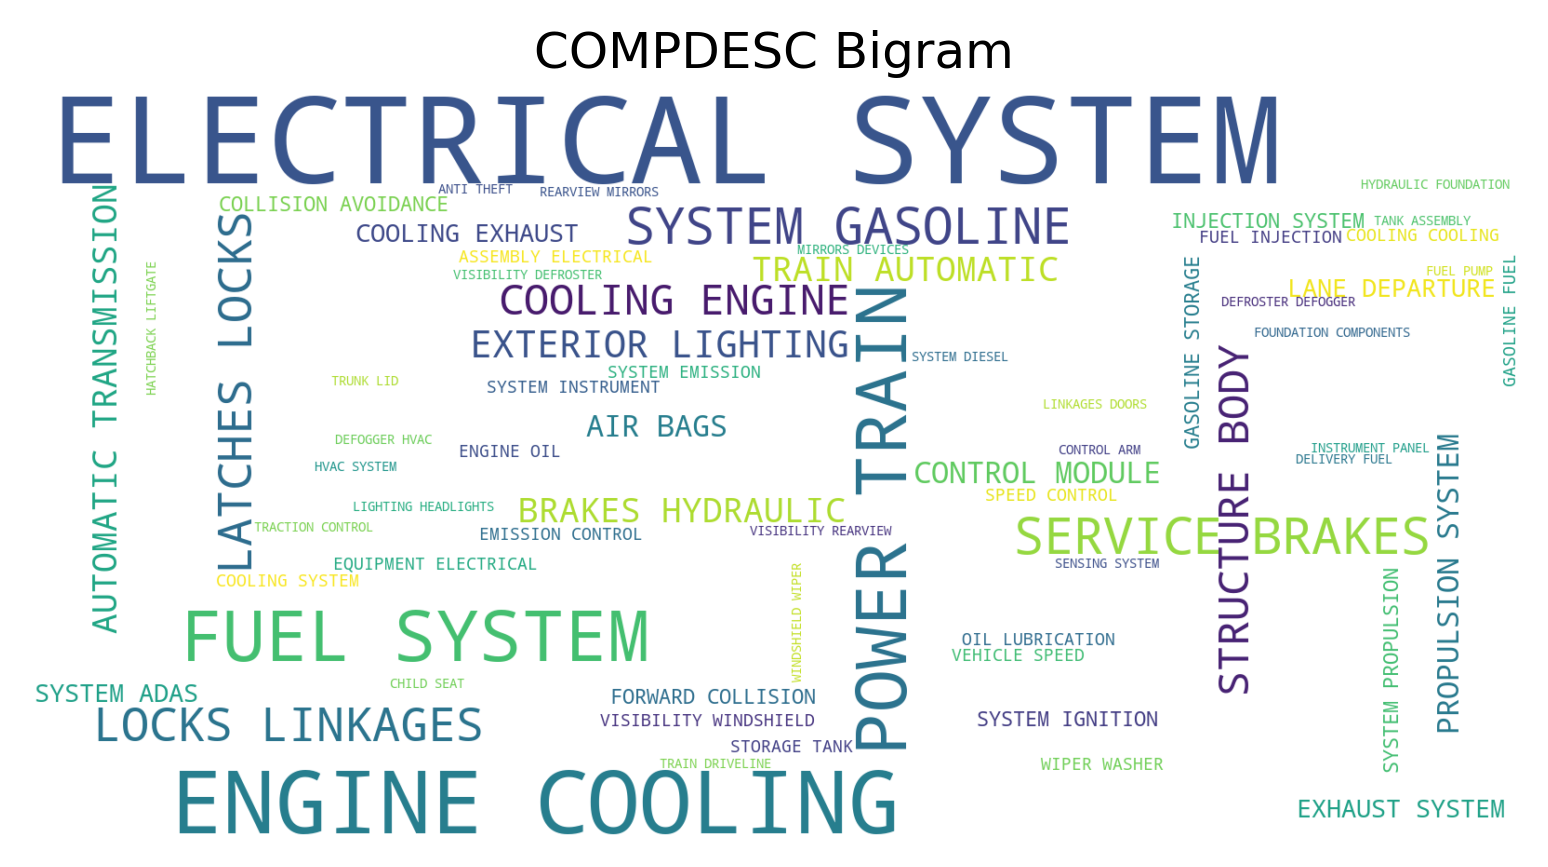

In [35]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPDESC Bigram')

# Data Quality Check

More in-depth analysis done on 2020-2024 dataset

In [40]:
num_unique_values_per_complaint = (
    (df_complaints.groupby("ODINO").nunique().sum(axis=0)
    - df_complaints["ODINO"].nunique())/df_complaints["ODINO"].nunique() + 1
).sort_values(ascending=False)

In [41]:
num_unique_values_per_complaint

COMPDESC             1.451487
PROD_TYPE            1.009067
MODELTXT             1.008982
YEARTXT              1.008982
MMYTXT               1.008982
MAKETXT              1.008813
MFR_NAME             1.008813
CRASH                1.000000
INJURED              1.000000
DEATHS               1.000000
STATE                1.000000
DATEA                1.000000
LDATE                1.000000
POLICE_RPT_YN        1.000000
FIRE                 1.000000
FAILDATE             1.000000
MEDICAL_ATTN         1.000000
CMPL_TYPE            1.000000
CITY                 0.999915
CDESCR               0.999661
VEHICLES_TOWED_YN    0.992712
ANTI_BRAKES_YN       0.992712
CRUISE_CONT_YN       0.992712
ORIG_OWNER_YN        0.992712
VIN                  0.985510
VEH_SPEED            0.468520
MILES                0.193882
DEALER_NAME          0.141768
DEALER_CITY          0.123295
DEALER_STATE         0.122617
DEALER_ZIP           0.113634
DEALER_TEL           0.076095
ORIG_EQUIP_YN        0.006864
SEAT_TYPE 

C:\Users\harri\AppData\Local\Temp\ipykernel_39112\1613427292.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


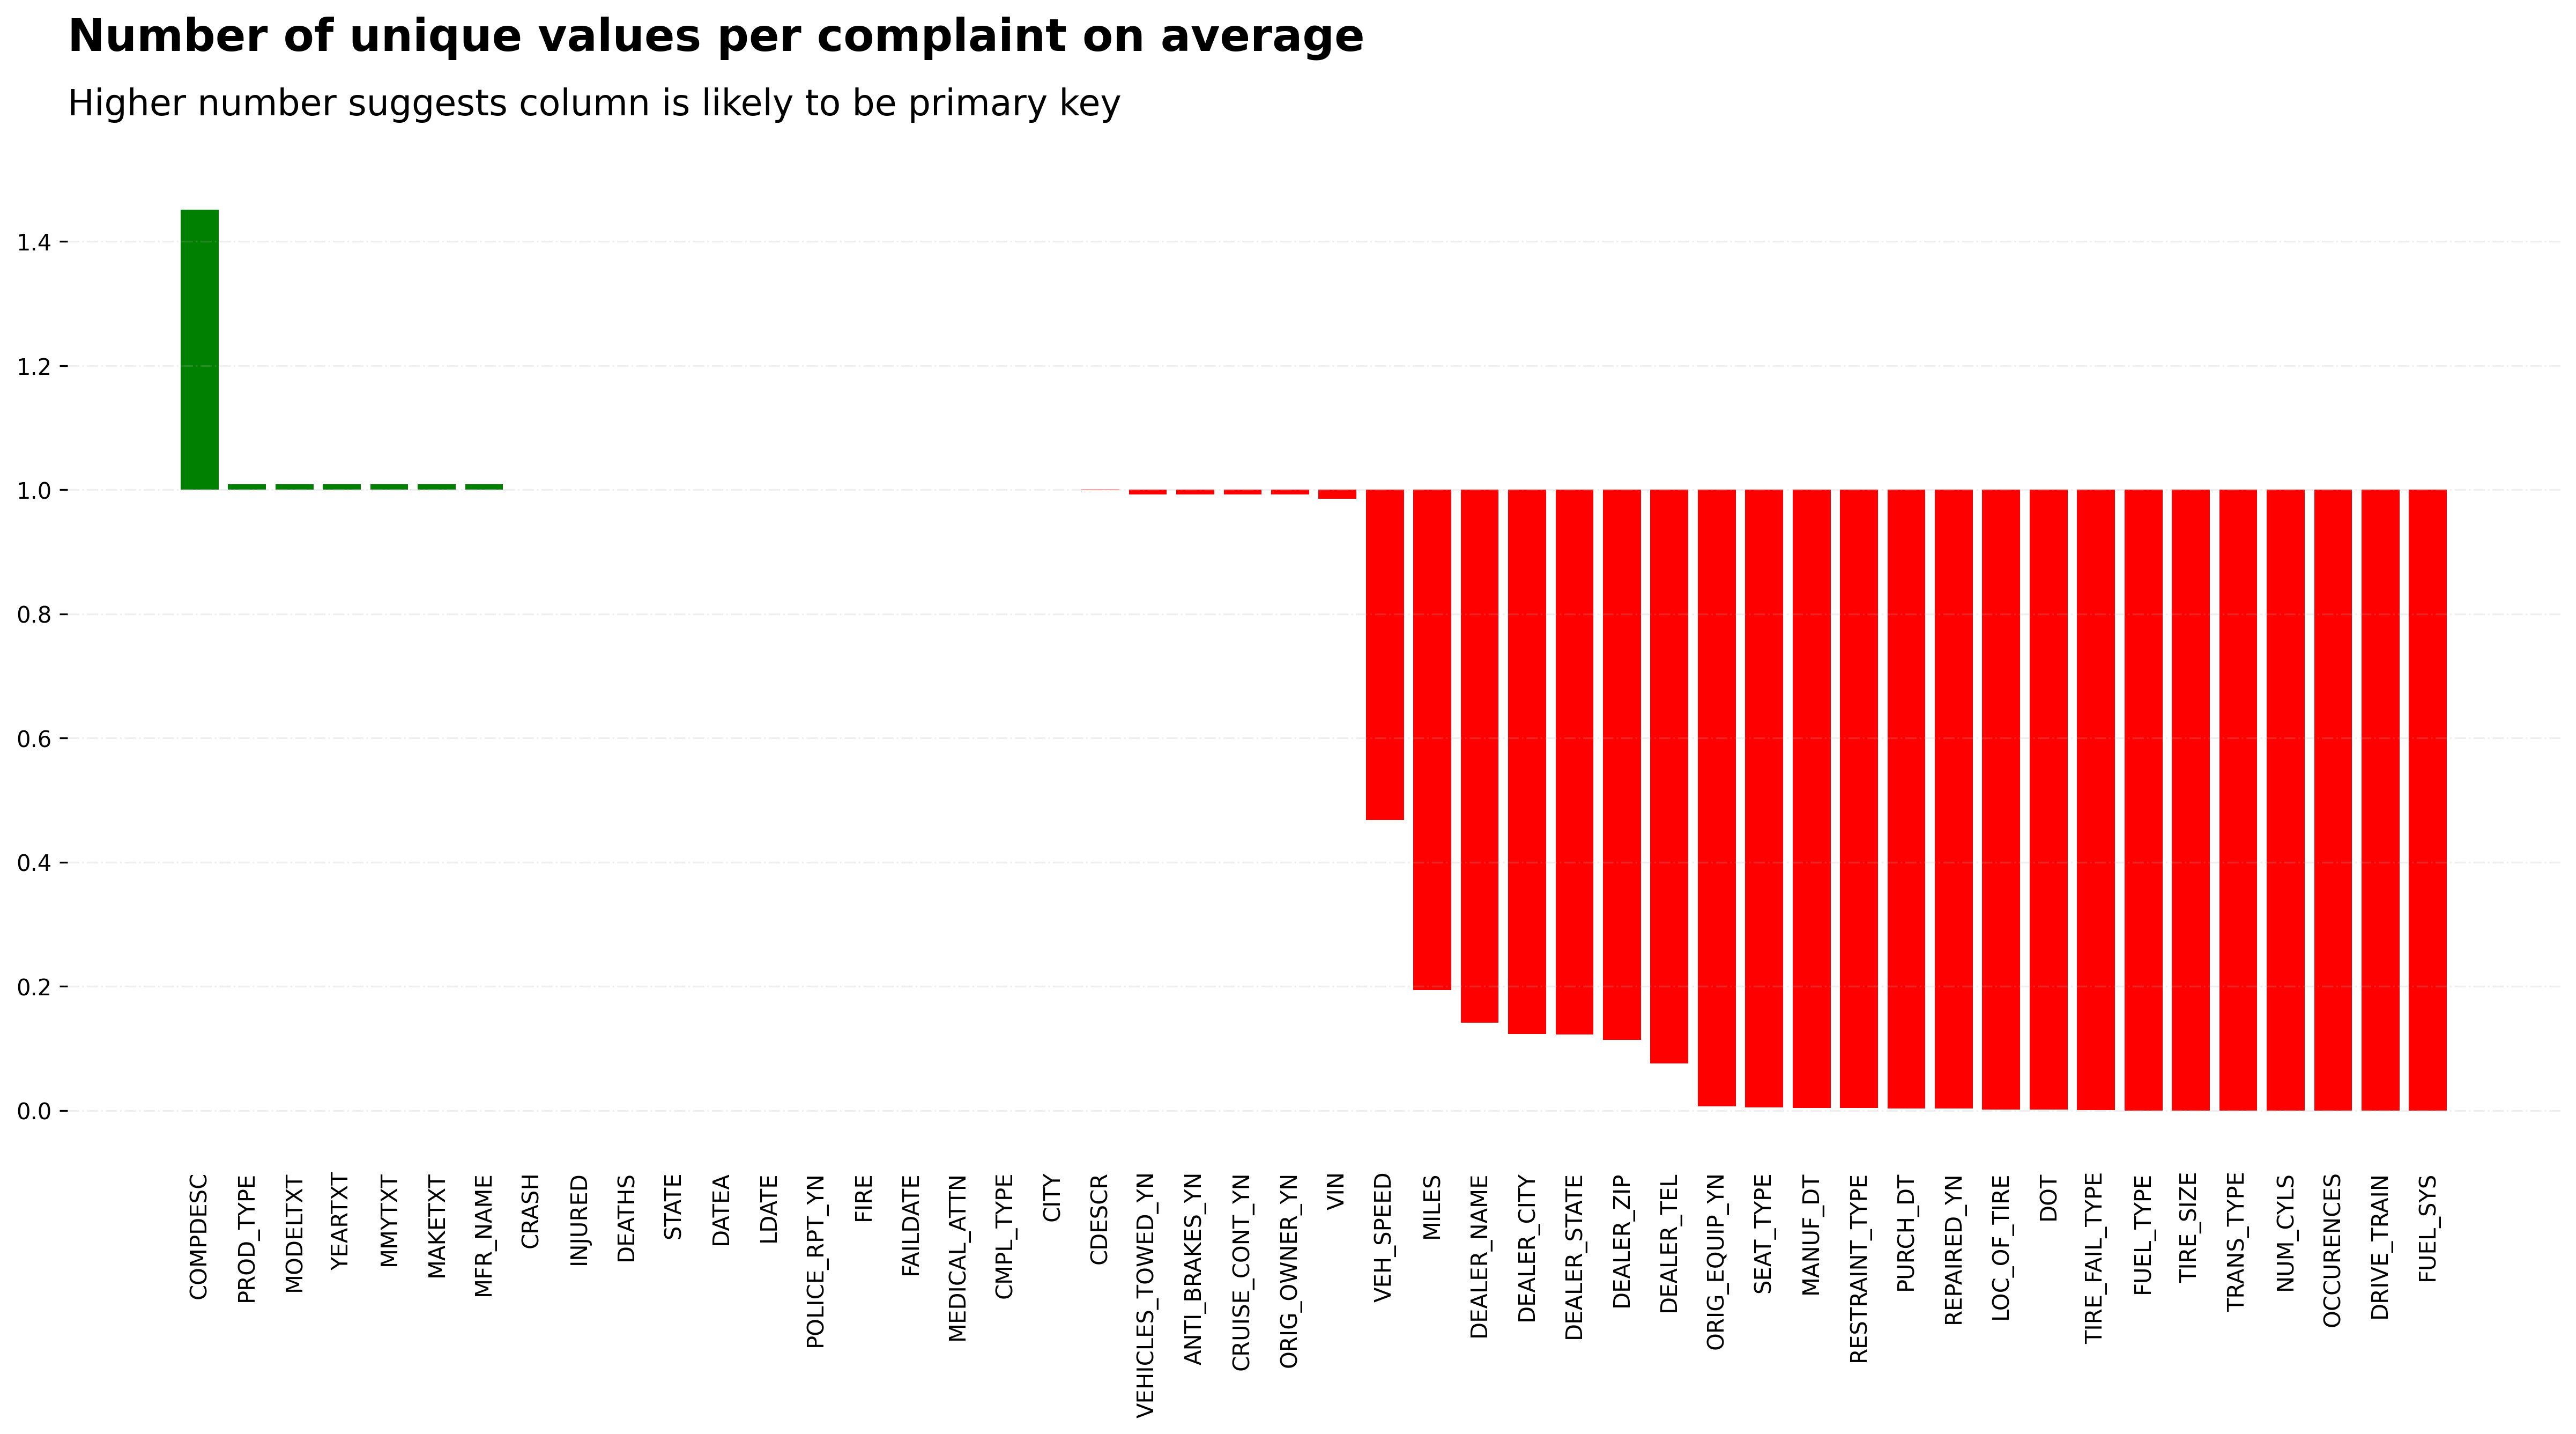

In [78]:
fig, ax = plt.subplots(figsize=(20, 8), dpi=300)
ax.bar(
    num_unique_values_per_complaint.index,
    height=num_unique_values_per_complaint - 1,
    color=np.where(num_unique_values_per_complaint > 1, "green", "red"),
    bottom=1
)
ax.tick_params(axis="x", color="white")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.spines["bottom"].set_visible(False)
ax.set_ylabel("")
plt.suptitle("Number of unique values per complaint on average", fontsize=20, fontweight=900,
             x=0, y=1.15, transform=ax.transAxes, ha="left")
_ = plt.title("Higher number suggests column is likely to be primary key", fontsize=16,
             x=0, y=1.05, transform=ax.transAxes, ha="left")


# Appendix

In [17]:
df_complaints.loc[
    df_complaints["ODINO"] == 11637459
]

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN,MMYTXT
0,,,,,,,,,,,,,,,,,,,,,
2057455,11637459,"Mitsubishi Motors North America, Inc.",MITSUBISHI,OUTLANDER SPORT,2015,N,20250121,N,0,0,...,,,,,,V,,N,N,MITSUBISHI OUTLANDER SPORT 2015


In [16]:
df_complaints.loc[
    df_complaints["ODINO"] == 11637459,
    "CDESCR"
].iloc[0]

''

In [15]:
df_complaints.loc[
    df_complaints["ODINO"] == 11641533,
    "CDESCR"
].iloc[0]

''